In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap
from scipy.spatial.distance import cdist
import anndata
import scanpy as sc
import scvi
from scvedge.vedge_model import VEDGE
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [ ]:
adata = anndata.read("../Data/adata_raw.h5ad.gz")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
FIGPATH='../Figures/my_crpt'
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["BLIS_NUM_THREADS"] = "1"
torch.set_num_threads(1)

In [ ]:
def depair_anndata(adata, n_unpaired):
    modality_switch = np.where(adata.var.modality == "Peaks")[0].min()
    
    indices = np.arange(adata.shape[0])
    np.random.shuffle(indices)
    unpaired_idx = indices[:n_unpaired]
    paired_idx = indices[n_unpaired:]
    
    adata_p = adata[paired_idx].copy()
    adata_np_acc = adata[unpaired_idx].copy()
    adata_np_exp = adata_np_acc.copy()
    
    adata_np_acc.X[:, :modality_switch] = 0
    adata_np_exp.X[:, modality_switch:] = 0
    
    adata = anndata.AnnData(
        scipy.sparse.vstack((adata_p.X, adata_np_acc.X, adata_np_exp.X)),
        obs=pd.concat((adata_p.obs, adata_np_acc.obs, adata_np_exp.obs)),
        var=adata_p.var
    )
    adata.X.eliminate_zeros()
    
    has_chr = np.asarray(adata.X[:, modality_switch:].sum(axis=1) > 0).squeeze()
    has_rna = np.asarray(adata.X[:, :modality_switch].sum(axis=1) > 0).squeeze()
    adata.obs["modality"] = "expression"
    adata.obs.modality.loc[has_chr] = "accessibility"
    adata.obs.modality.loc[np.logical_and(has_chr, has_rna)] = "paired"
    return adata.copy()

def corrupt_and_process(adata, unpaired_rate):
    if os.path.exists("../Data/vedge_corruption/adata_r{}.h5ad.gz".format(int(unpaired_rate * 100))):
        print("already done, skipping!")
        return
    print("corrupting AnnData...")
    adata = depair_anndata(adata, int(unpaired_rate * adata.shape[0]))
    print("training model...")
    VEDGE.setup_anndata(adata, batch_key='modality')
    mvi = VEDGE(adata, 
                    (adata.var.modality=='Gene Expression').sum(), 
                    (adata.var.modality=='Peaks').sum(),
                    use_batch_norm='decoder',
                    fully_paired=False
                 )
    mvi.train(batch_size = 32,
             early_stopping = True,
             early_stopping_patience = 50,
             adversarial_mixing=True)
    adata.obsm["X_MultiVI"] = mvi.get_latent_representation()
    sc.pp.neighbors(adata, use_rep="X_MultiVI")
    sc.tl.umap(adata, min_dist=0.2)
    adata.write("../Data/vedge_corruption/adata_r{}.h5ad.gz".format(int(unpaired_rate * 100)), compression='gzip')
    mvi.save("../model_trained/vedge_corruption/mvi_r{}".format(int(unpaired_rate * 100)))

In [ ]:
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
for npp in NPPs:
    print(npp)
    corrupt_and_process(adata, npp)

0.0


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


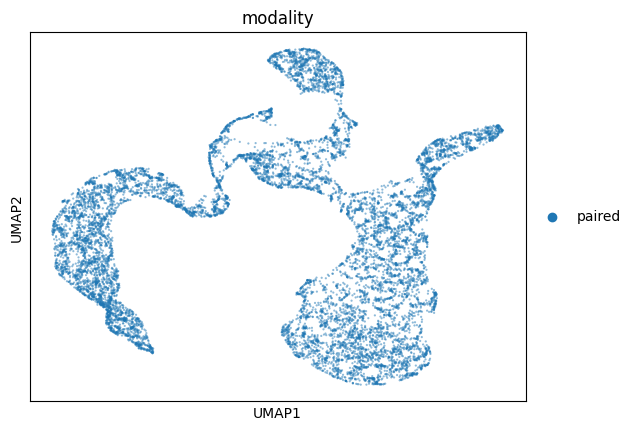

0.01


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


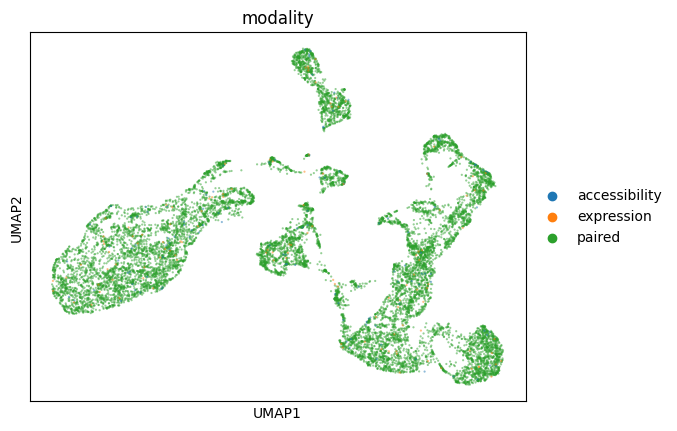

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


0.1


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


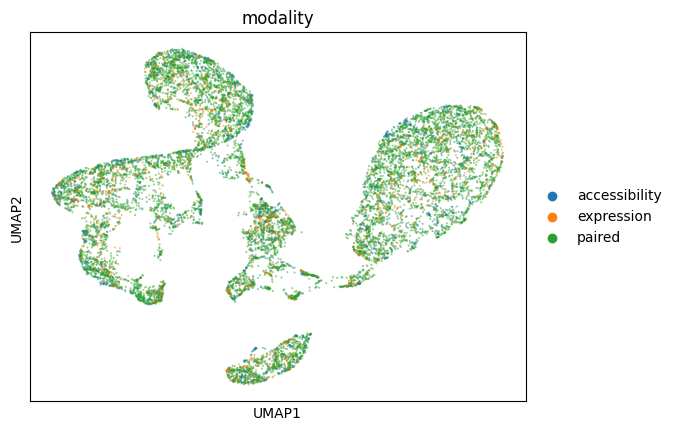

0.25


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


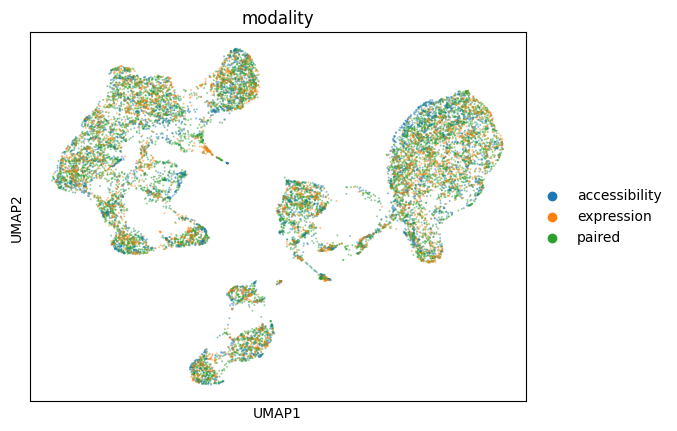

0.5


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


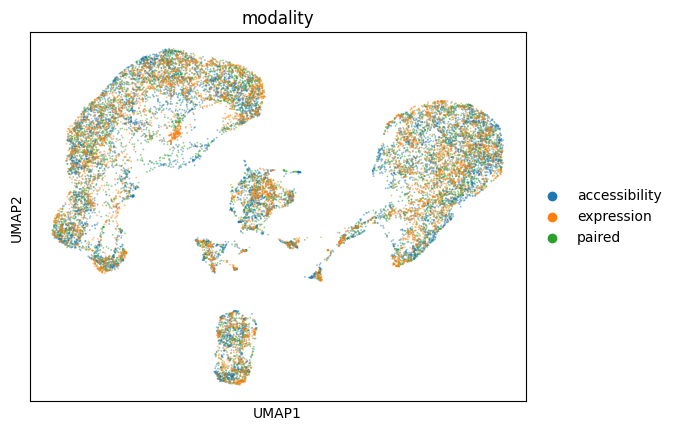

0.75


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


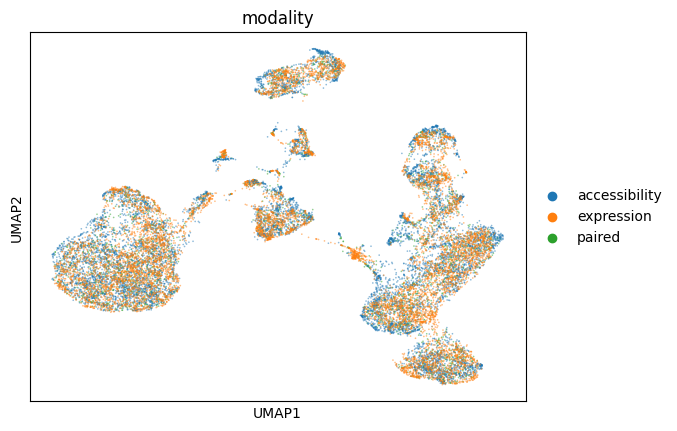

0.9


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


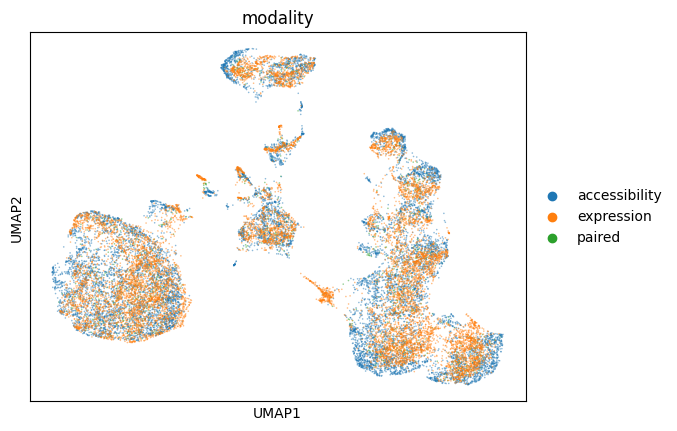

0.99


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


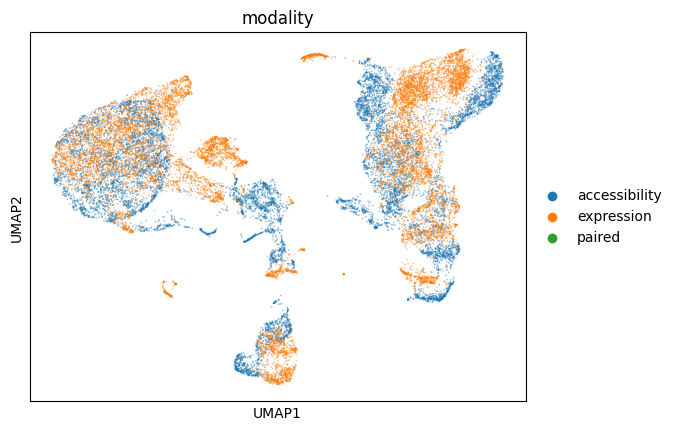

1


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


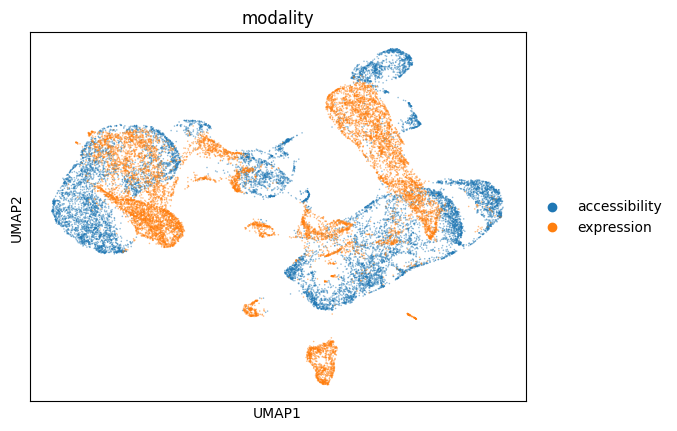

In [ ]:
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
for npp in NPPs:
    print(npp)
    adata = anndata.read("../Data/vedge_corruption/adata_r{}.h5ad.gz".format(int(npp * 100)))
    sc.pl.umap(adata, color='modality', alpha=0.5)

In [3]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [4]:
def compute_foscttm(latent_acc, latent_exp):
    """
    计算 FOSCTTM 分数
    
    返回: 平均 FOSCTTM 值
    """
    distances = cdist(latent_acc, latent_exp, metric='euclidean')  # 计算所有细胞的欧式距离
    foscttm_values = []
    num_cells=latent_exp.shape[0]

    for i in range(num_cells):  # 遍历所有已知匹配的细胞对
        d_true = distances[i, i]  # 真实匹配的距离
        d_others = distances[i, :]  # 该细胞到所有其他细胞的距离
        
        rank = np.sum(d_others < d_true) / num_cells  # 计算 FOSCTTM
        foscttm_values.append(rank)

    return np.mean(foscttm_values)  # 返回平均 FOSCTTM 值

In [ ]:
distances = []
enrichments = []
foscttms=[]
asw_modality=[]
NPPs = [0.0, 0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
for npp in NPPs[1:-1]:
    print(npp)
    adata = anndata.read("../Data/vedge_corruption/adata_r{}.h5ad.gz".format(int(npp * 100)))
    latent = adata.obsm['X_MultiVI']
    for K in [15,50,150,500]:
        print(K)
        enrichments.append((
            npp, 
            K, 
            compute_batch_mixing(latent, adata.obs.modality, K),
        ))
    latent_exp = latent[adata.obs.modality == 'expression']
    latent_acc = latent[adata.obs.modality == 'accessibility']
    distances.append(pd.DataFrame({
        'rate':npp,
        'distances':(((latent_exp - latent_acc) ** 2).sum(axis=1) ** 0.5),
    }))
    foscttms.append((npp,compute_foscttm(latent_acc,latent_exp)))
    asw_modality.append((npp,silhouette_score(latent, adata.obs["modality"], metric='euclidean')))

0.01


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.1


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.25


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.5


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.75


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.9


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500
0.99


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


15
50
150
500


<Axes: xlabel='rate', ylabel='enrichment'>

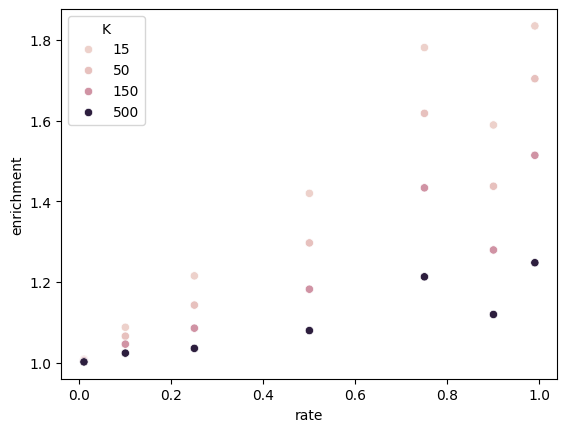

In [11]:
df_enrich = pd.DataFrame(enrichments, columns=('rate', 'K', 'enrichment'))
sns.scatterplot(data=df_enrich, x='rate', y='enrichment', hue='K')

In [9]:
[x[2] for x in enrichments if x[1] == 500]

[1.0015653270296383,
 1.0233989896822733,
 1.0351602942512033,
 1.0793476523476524,
 1.1842117531591216,
 1.119290892394598,
 1.2477007432183211]

<Axes: xlabel='rate', ylabel='distances'>

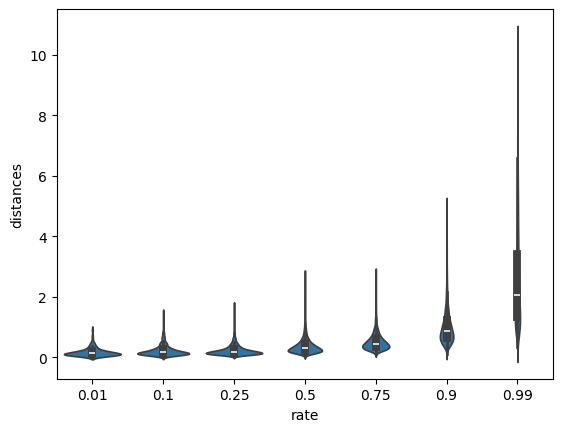

In [12]:
dist_df = pd.concat(distances)
sns.violinplot(data=dist_df, x='rate', y='distances')

In [18]:
dist_mean = [distances[0].distances.mean(), distances[1].distances.mean(), distances[2].distances.mean(), distances[3].distances.mean(), 
             distances[4].distances.mean(), distances[5].distances.mean(), distances[6].distances.mean()]
dist_mean

[0.17585084,
 0.23044583,
 0.23667149,
 0.38048637,
 0.7099499,
 1.0085211,
 2.5686994]

In [13]:
foscttms

[(0.01, 0.04111111111111111),
 (0.1, 0.05460409414580272),
 (0.25, 0.04388185906667426),
 (0.5, 0.0478248580146682),
 (0.75, 0.03777542372280967),
 (0.9, 0.05399786575112467),
 (0.99, 0.141858036161605)]

In [14]:
asw_modality

[(0.01, 2.570558e-05),
 (0.1, -0.007653988),
 (0.25, -0.012206165),
 (0.5, -0.008862743),
 (0.75, -0.017612107),
 (0.9, -0.02598193),
 (0.99, -0.10634749)]